In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Hyper params

In [2]:
# output directory name:
output_dir = 'model_output/biLSTM'

# training:
epochs = 6
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2


### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17465344/17464789 [==============================] - 0s 0us/step


### Pre-process data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### NN architecture

In [5]:
model = Sequential()

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid'))
# LSTM layer parameters double due to both reading directions
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               657408    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


### Model Config

In [6]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Training

In [7]:
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/6
196/196 [==============================] - 39s 200ms/step - loss: 0.6143 - accuracy: 0.6776 - val_loss: 0.5446 - val_accuracy: 0.7234
Epoch 2/6
196/196 [==============================] - 38s 194ms/step - loss: 0.5161 - accuracy: 0.7587 - val_loss: 0.5886 - val_accuracy: 0.6949
Epoch 3/6
196/196 [==============================] - 38s 195ms/step - loss: 0.5046 - accuracy: 0.7554 - val_loss: 0.4988 - val_accuracy: 0.7484
Epoch 4/6
196/196 [==============================] - 38s 194ms/step - loss: 0.3960 - accuracy: 0.8282 - val_loss: 0.3921 - val_accuracy: 0.8349
Epoch 5/6
196/196 [==============================] - 38s 194ms/step - loss: 0.3026 - accuracy: 0.8744 - val_loss: 0.3301 - val_accuracy: 0.8582
Epoch 6/6
196/196 [==============================] - 38s 196ms/step - loss: 0.2416 - accuracy: 0.9054 - val_loss: 0.3419 - val_accuracy: 0.8590


### Model Evaluation

In [16]:
model.load_weights(output_dir+"/weights.05.hdf5")

In [17]:
y_hat = model.predict(x_valid)

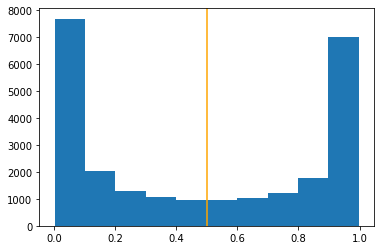

In [18]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [19]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'93.40'